In [120]:
import pandas as pd
import numpy as np
import collections
import copy
import sklearn.metrics.pairwise as pairwise
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Dataset Construction

In [121]:
NUM_TAGS_USED = 10000
NUM_MOVIES = 200
NUM_USERS = 400

In [122]:
ratings_data = pd.read_table('data/ratings.dat', delimiter='::')
for column in ['UserID', 'MovieID', 'Rating']:
    ratings_data[column] = ratings_data[column].astype(int)
    
used_movie_ids = ratings_data['MovieID'].value_counts().index.tolist()[:NUM_MOVIES]
ratings_data = ratings_data[ratings_data['MovieID'].isin(used_movie_ids)]

movie_ids = sorted(ratings_data['MovieID'].unique())
movieIDDictionary = {tag: i for i, tag in enumerate(movie_ids)}
ratings_data['MovieID'] = (ratings_data['MovieID'].map(movieIDDictionary)).astype(int)
ratings_data = ratings_data[ratings_data['MovieID'] < NUM_MOVIES]

/Users/rbais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [123]:
used_User_ids = ratings_data['UserID'].value_counts().index.tolist()[:NUM_USERS]
ratings_data = ratings_data[ratings_data['UserID'].isin(used_User_ids)]

User_ids = sorted(ratings_data['UserID'].unique())
UserIDDictionary = {tag: i for i, tag in enumerate(User_ids)}
ratings_data['UserID'] = (ratings_data['UserID'].map(UserIDDictionary)).astype(int)
ratings_data = ratings_data[ratings_data['UserID'] < NUM_USERS]

In [124]:
movies_data = pd.read_table('data/movies.dat', delimiter='::')
movie_id_to_title = {}
for index, row in movies_data.iterrows():
    if int(row['MovieID']) in movieIDDictionary:
        movie_id_to_title[movieIDDictionary[int(row['MovieID'])]] = row['MovieTitle']

/Users/rbais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [125]:
tags_data = pd.read_table('data/tags.dat', delimiter='::')
tags_data['tag'] = tags_data['tag'].astype(str).str.lower().str.strip()
tags = sorted(tags_data['tag'].unique())

used_tags = tags_data['tag'].value_counts().index.tolist()[:NUM_TAGS_USED]
tags_data = tags_data[tags_data['tag'].isin(used_tags)]

tags_data['tag'] = tags_data['tag'].astype(str).str.lower().str.strip()

tags = sorted(tags_data['tag'].unique())
tagDictionary = {tag: i for i, tag in enumerate(tags)}
tags_data['tagID'] = (tags_data['tag'].map(tagDictionary)).astype(int)
#tags_data = tags_data[tags_data['movieID']]
tags_data['movieID'] = (tags_data['movieID'].map(movieIDDictionary))
tags_data = tags_data.dropna()
tags_data['movieID'] = tags_data['movieID'].astype(int)
tags_data = tags_data[tags_data['movieID'] < NUM_MOVIES]

Rmt = np.zeros((NUM_MOVIES, NUM_TAGS_USED))
for i, row in tags_data.iterrows():
    Rmt[row['movieID'] - 1][row['tagID'] - 1] = 1

/Users/rbais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [126]:
ratings_data.shape
ratings_data.to_csv('data/reduced_ratings.csv')

In [127]:
"""
num_movies = max(ratings_data['MovieID'])
num_users = max(ratings_data['UserID'])

reduced_ratings_data = ratings_data[(ratings_data['MovieID'] < NUM_MOVIES + 1) & (ratings_data['UserID'] < NUM_USERS + 1)]
reduced_ratings_data.to_csv('data/reduced_ratings.csv')
"""

"\nnum_movies = max(ratings_data['MovieID'])\nnum_users = max(ratings_data['UserID'])\n\nreduced_ratings_data = ratings_data[(ratings_data['MovieID'] < NUM_MOVIES + 1) & (ratings_data['UserID'] < NUM_USERS + 1)]\nreduced_ratings_data.to_csv('data/reduced_ratings.csv')\n"

In [128]:
reduced_ratings_data = pd.read_csv('data/reduced_ratings.csv')
Rmu = np.zeros((NUM_MOVIES, NUM_USERS))
for i, row in reduced_ratings_data.iterrows(): 
    Rmu[row['MovieID'] - 1][row['UserID'] - 1] = row['Rating']

## Baseline Collaborative Filtering

In [129]:
np.random.seed(88)

non_zero_movies_indeces, non_zero_users_indeces = np.nonzero(Rmu) #Movie to Users
non_zero_ratings_indeces = [(i, j) for i, j in zip(non_zero_movies_indeces, non_zero_users_indeces)]
blanked_ratings = [non_zero_ratings_indeces[random_i] for random_i in np.random.choice(len(non_zero_ratings_indeces), int(len(non_zero_ratings_indeces)/10),  replace=False)]
    
def collaborative_filtering(Rmu, Muu, Mtt, alpha=0.5, beta=0.5):
    assert(Rmu.shape == (NUM_MOVIES, NUM_USERS))
    assert(Muu.shape[0] == Rmu.shape[0])
    assert(Mtt.shape[0] == Rmu.shape[0])
    
    assert(alpha+beta == 1)
    
    Suu = 1 - pairwise_distances(Muu, metric="cosine")
    Stt = 1 - pairwise_distances(Mtt, metric="cosine")

    actual_ratings = [Rmu[idx] for idx in blanked_ratings]
    
    actual_used_ratings = []
    predicted_ratings = []
    
    for i, (movie_idx, user_idx) in enumerate(blanked_ratings):
        #most_similar_movies = np.argsort(-Smm[movie_idx])
    
        similarity_sum = 0
        weighted_ratings_sum = 0
        for similar_movie_idx in range(NUM_MOVIES): #most_similar_movies
            if actual_ratings[similar_movie_idx] == 0:
                continue
                
            if similar_movie_idx != movie_idx:
                #import pdb; pdb.set_trace()
                similarity = alpha * Suu[movie_idx][similar_movie_idx] + beta * Stt[movie_idx][similar_movie_idx]
                similarity_sum += similarity
                weighted_ratings_sum += actual_ratings[similar_movie_idx] * similarity
        
        pred_rating = weighted_ratings_sum / similarity_sum
        if pred_rating >= 1 and pred_rating <= 5:
            actual_used_ratings.append(actual_ratings[i])
            predicted_ratings.append(pred_rating)
    return mean_squared_error(predicted_ratings, actual_used_ratings)

In [130]:
alphas = [a / 5.0 for a in range(0, 6)]
num_component_hyperparams = [3, 5, 10, 25, 50]
RMSE_baseline = []
RMSE_hyperparam_vals = np.zeros((len(num_component_hyperparams), len(alphas)))

for a in range(0, 6):
    alpha = a / 5.0
    beta = 1.0 - alpha
    print ('alpha: %.1f, beta: %.1f' %(alpha, beta))
    
    rmse_baseline = collaborative_filtering(Rmu, Rmu, Rmt, alpha = alpha, beta = beta)
    print ('Baseline Performance: ', rmse_baseline)
    RMSE_baseline.append(rmse_baseline)
    
    for i, n in enumerate(num_component_hyperparams):
        pca_Rmt = PCA(n_components=n).fit_transform(Rmt)
        #pca_Rmu = PCA(n_components=n).fit_transform(Rmu)
        rmse_pca = collaborative_filtering(Rmu, Rmu, pca_Rmt, alpha = alpha, beta = beta)
        
        RMSE_hyperparam_vals[i][a] = rmse_pca
        print ('Performance with PCA n_components=%d: %f' %(n, rmse_pca))

alpha: 0.0, beta: 1.0
Baseline Performance:  1.0175792025175758
Performance with PCA n_components=3: 1.123923
Performance with PCA n_components=5: 1.161213
Performance with PCA n_components=10: 1.131266
Performance with PCA n_components=25: 1.157477
Performance with PCA n_components=50: 1.179928
alpha: 0.2, beta: 0.8
Baseline Performance:  1.0049549541586613
Performance with PCA n_components=3: 1.097570
Performance with PCA n_components=5: 1.065128
Performance with PCA n_components=10: 1.021121
Performance with PCA n_components=25: 1.018249
Performance with PCA n_components=50: 1.020021
alpha: 0.4, beta: 0.6
Baseline Performance:  1.0055048698753635
Performance with PCA n_components=3: 1.010643
Performance with PCA n_components=5: 1.000229
Performance with PCA n_components=10: 1.006605
Performance with PCA n_components=25: 1.008125
Performance with PCA n_components=50: 1.011005
alpha: 0.6, beta: 0.4
Baseline Performance:  1.0057635570294519
Performance with PCA n_components=3: 1.007780

Text(0.5, 1.0, 'RMSE using PCA on Tag Matrix')

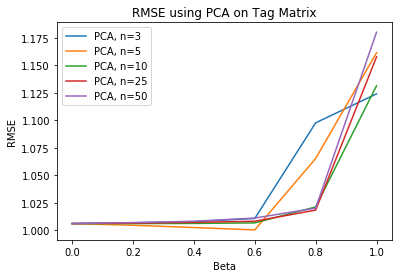

In [131]:
betas = [1 - alpha for alpha in alphas]
#plt.plot(betas, RMSE_baseline)
for i in range(len(num_component_hyperparams)):
    plt.plot(betas, RMSE_hyperparam_vals[i])
plt.legend(['PCA, n=%d' %(n) for i, n in enumerate(num_component_hyperparams)])
plt.xlabel('Beta')
plt.ylabel('RMSE')
plt.title('RMSE using PCA on Tag Matrix')

Text(0.5, 1.0, 'Baseline on Tag Matrix RMSE')

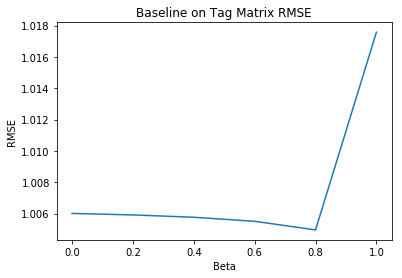

In [132]:
plt.plot(betas, RMSE_baseline)
plt.xlabel('Beta')
plt.ylabel('RMSE')
plt.title('Baseline on Tag Matrix RMSE')

Text(0.5, 1.0, 'RMSE by Number of PCA Components')

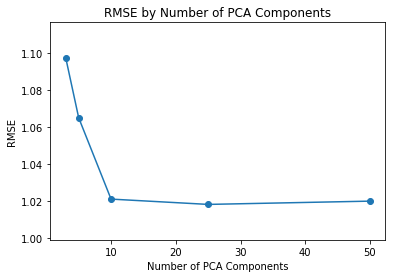

In [133]:
y = []
for i in range(len(num_component_hyperparams)):
    y.append(RMSE_hyperparam_vals[i][1])
    
plt.scatter([n for i, n in enumerate(num_component_hyperparams)], y)
plt.plot([n for i, n in enumerate(num_component_hyperparams)], y)
plt.xlabel('Number of PCA Components')
plt.ylabel('RMSE')
plt.title('RMSE by Number of PCA Components')

In [134]:
print (RMSE_hyperparam_vals[0][1])
RMSE_hyperparam_vals[1][1]
RMSE_hyperparam_vals[2][1]

1.097570403115554


1.0211213638951127

In [135]:
len(RMSE_hyperparam_vals[0])

6

In [136]:
from sklearn.decomposition import FactorAnalysis
print (Rmt.shape)
transformer = FactorAnalysis(n_components=7, random_state=0)
Rmt_transformed = transformer.fit_transform(Rmt)
print (Rmt_transformed.shape)

(200, 10000)
(200, 7)


In [137]:
print(movie_id_to_title)

{0: 'Toy Story (1995)', 1: 'Jumanji (1995)', 2: 'Heat (1995)', 3: 'GoldenEye (1995)', 4: 'American President, The (1995)', 5: 'Casino (1995)', 6: 'Sense and Sensibility (1995)', 7: 'Ace Ventura: When Nature Calls (1995)', 8: 'Get Shorty (1995)', 9: 'Leaving Las Vegas (1995)', 10: '12 Monkeys (Twelve Monkeys) (1995)', 11: 'Babe (1995)', 12: 'Dead Man Walking (1995)', 13: 'Clueless (1995)', 14: 'Seven (a.k.a. Se7en) (1995)', 15: 'Usual Suspects, The (1995)', 16: "Mr. Holland's Opus (1995)", 17: 'Broken Arrow (1996)', 18: 'Happy Gilmore (1996)', 19: 'Braveheart (1995)', 20: 'Taxi Driver (1976)', 21: 'Birdcage, The (1996)', 22: 'Apollo 13 (1995)', 23: 'Batman Forever (1995)', 24: 'Crimson Tide (1995)', 25: 'Die Hard: With a Vengeance (1995)', 26: 'Net, The (1995)', 27: 'Waterworld (1995)', 28: 'Clerks (1994)', 29: 'Dumb & Dumber (1994)', 30: 'Ed Wood (1994)', 31: 'Interview with the Vampire: The Vampire Chronicles (1994)', 32: 'Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)',

In [138]:
# Given movie to item matrix get the movie movie adjacency
def get_movie_adjacency(Mmi):
    newM = np.zeros((len(Mmi), len(Mmi)))
    for i in range(len(Mmi)):
        for j in range(len(Mmi)):
            emb_1 = Mmi[i,:]
            emb_2 = Mmi[j,:]
            cos_score = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
            newM[i,j] = cos_score
    return newM
    

In [139]:
M_tt = get_movie_adjacency(Rmt)
M_uu = get_movie_adjacency(Rmu)

In [140]:
W = M_tt

In [141]:
D = np.diag(W.sum(axis=1))

In [142]:
L = D - W

In [143]:
w, v = np.linalg.eigh(L)

In [144]:
from sklearn.manifold import TSNE
m_embeds = TSNE(n_components=2, n_iter=10000).fit_transform(v)

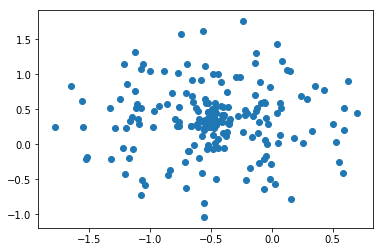

In [145]:
plt.scatter(m_embeds[:,0], m_embeds[:,1])

In [146]:
from sklearn.decomposition import TruncatedSVD

In [147]:
alphas = [a / 5.0 for a in range(0, 6)]
num_component_hyperparams = [3, 5, 10, 25, 50]
RMSE_baseline = []
RMSE_hyperparam_vals = np.zeros((len(num_component_hyperparams), len(alphas)))

for a in range(0, 6):
    alpha = a / 5.0
    beta = 1.0 - alpha
    print ('alpha: %.1f, beta: %.1f' %(alpha, beta))
    
    rmse_baseline = collaborative_filtering(Rmu, Rmu, Rmt, alpha = alpha, beta = beta)
    print ('Baseline Performance: ', rmse_baseline)
    RMSE_baseline.append(rmse_baseline)
    
    for i, n in enumerate(num_component_hyperparams):
        svd = TruncatedSVD(n_components=n, n_iter=100, random_state=42)
        Rmt_red = svd.fit_transform(Rmt)
        rmse_svd = collaborative_filtering(Rmu, Rmu, Rmt_red, alpha = alpha, beta = beta)
        
        RMSE_hyperparam_vals[i][a] = rmse_svd
        print ('Performance with SVD n_components=%d: %f' %(n, rmse_svd))

alpha: 0.0, beta: 1.0
Baseline Performance:  1.0175792025175758
Performance with SVD n_components=3: 1.005620
Performance with SVD n_components=5: 1.018930
Performance with SVD n_components=10: 1.014248
Performance with SVD n_components=25: 1.017244
Performance with SVD n_components=50: 1.022362
alpha: 0.2, beta: 0.8
Baseline Performance:  1.0049549541586613
Performance with SVD n_components=3: 1.005797
Performance with SVD n_components=5: 1.014333
Performance with SVD n_components=10: 1.009235
Performance with SVD n_components=25: 1.007941
Performance with SVD n_components=50: 1.006526
alpha: 0.4, beta: 0.6
Baseline Performance:  1.0055048698753635
Performance with SVD n_components=3: 1.005897
Performance with SVD n_components=5: 1.011241
Performance with SVD n_components=10: 1.007496
Performance with SVD n_components=25: 1.006628
Performance with SVD n_components=50: 1.005928
alpha: 0.6, beta: 0.4
Baseline Performance:  1.0057635570294519
Performance with SVD n_components=3: 1.005955

Text(0.5, 1.0, 'RMSE using SVD on Tag Matrix')

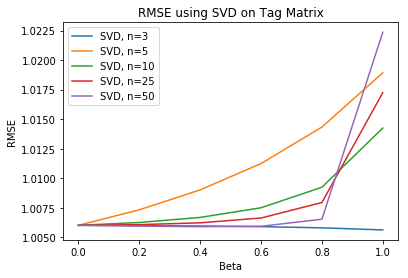

In [148]:
betas = [1 - alpha for alpha in alphas]
#plt.plot(betas, RMSE_baseline)
for i in range(len(num_component_hyperparams)):
    plt.plot(betas, RMSE_hyperparam_vals[i])
plt.legend(['SVD, n=%d' %(n) for i, n in enumerate(num_component_hyperparams)])
plt.xlabel('Beta')
plt.ylabel('RMSE')
plt.title('RMSE using SVD on Tag Matrix')

In [149]:
alphas = [a / 5.0 for a in range(0, 6)]
RMSE_baseline = []
RMSE_embeds = []

for a in range(0, 6):
    alpha = a / 5.0
    beta = 1.0 - alpha
    print ('alpha: %.1f, beta: %.1f' %(alpha, beta))
    
    rmse_baseline = collaborative_filtering(Rmu, Rmu, Rmt, alpha = alpha, beta = beta)
    print ('Baseline Performance: ', rmse_baseline)
    RMSE_baseline.append(rmse_baseline)
    
    rmse_emb = collaborative_filtering(Rmu, Rmu, v, alpha = alpha, beta = beta)
    print ('Spectral Clustering Performance: ', rmse_emb)
    RMSE_embeds.append(rmse_emb)
    
    

alpha: 0.0, beta: 1.0
Baseline Performance:  1.0175792025175758


/Users/rbais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Spectral Clustering Performance:  1.9632986122893452
alpha: 0.2, beta: 0.8
Baseline Performance:  1.0049549541586613
Spectral Clustering Performance:  1.0060084808076784
alpha: 0.4, beta: 0.6
Baseline Performance:  1.0055048698753635
Spectral Clustering Performance:  1.0060084808076786
alpha: 0.6, beta: 0.4
Baseline Performance:  1.0057635570294519
Spectral Clustering Performance:  1.0060084808076784
alpha: 0.8, beta: 0.2
Baseline Performance:  1.0059122003137193
Spectral Clustering Performance:  1.0060084808076784
alpha: 1.0, beta: 0.0
Baseline Performance:  1.0060084808076784
Spectral Clustering Performance:  1.0060084808076784


Text(0.5, 1.0, 'Tag Matrix RMSE Spectral Clustering Comparison using k=128')

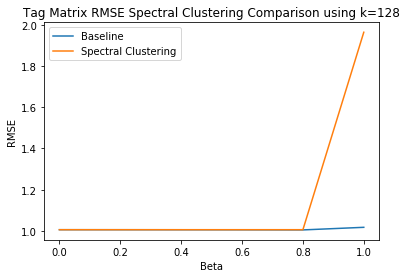

In [150]:
plt.plot(betas, RMSE_baseline)
plt.plot(betas, RMSE_embeds)
plt.xlabel('Beta')
plt.ylabel('RMSE')
plt.legend(['Baseline', 'Spectral Clustering'])

plt.title('Tag Matrix RMSE Spectral Clustering Comparison using k=128')

In [151]:
def JL_reduction(k, M):
    # given an M x N matrix, turn into M x k
    # k x N by N x M = k x M
    M_t = np.array(M).T
    n = M_t.shape[0]
    dim = np.random.randn(k, n)
    reduced_T = np.dot(dim, M_t)
    return reduced_T.T

In [152]:
alphas = [a / 5.0 for a in range(0, 6)]
num_component_hyperparams = [3, 5, 10, 25, 50]
RMSE_baseline = []
RMSE_hyperparam_vals = np.zeros((len(num_component_hyperparams), len(alphas)))

for a in range(0, 6):
    alpha = a / 5.0
    beta = 1.0 - alpha
    print ('alpha: %.1f, beta: %.1f' %(alpha, beta))
    
    rmse_baseline = collaborative_filtering(Rmu, Rmu, Rmt, alpha = alpha, beta = beta)
    print ('Baseline Performance: ', rmse_baseline)
    RMSE_baseline.append(rmse_baseline)
    
    for i, n in enumerate(num_component_hyperparams):
        reduced = JL_reduction(n, Rmt)
        rmse_jl = collaborative_filtering(Rmu, Rmu, reduced, alpha = alpha, beta = beta)
        
        RMSE_hyperparam_vals[i][a] = rmse_jl
        print ('Performance with JL n_components=%d: %f' %(n, rmse_jl))

alpha: 0.0, beta: 1.0
Baseline Performance:  1.0175792025175758
Performance with JL n_components=3: 1.256399
Performance with JL n_components=5: 1.131294
Performance with JL n_components=10: 1.307042
Performance with JL n_components=25: 1.125453
Performance with JL n_components=50: 1.202518
alpha: 0.2, beta: 0.8
Baseline Performance:  1.0049549541586613
Performance with JL n_components=3: 1.038501
Performance with JL n_components=5: 1.040664
Performance with JL n_components=10: 1.015804
Performance with JL n_components=25: 1.004634
Performance with JL n_components=50: 1.000660
alpha: 0.4, beta: 0.6
Baseline Performance:  1.0055048698753635
Performance with JL n_components=3: 1.000186
Performance with JL n_components=5: 1.012971
Performance with JL n_components=10: 1.007916
Performance with JL n_components=25: 1.007475
Performance with JL n_components=50: 1.006214
alpha: 0.6, beta: 0.4
Baseline Performance:  1.0057635570294519
Performance with JL n_components=3: 1.004822
Performance wit

Text(0.5, 1.0, 'RMSE using JL on Tag Matrix')

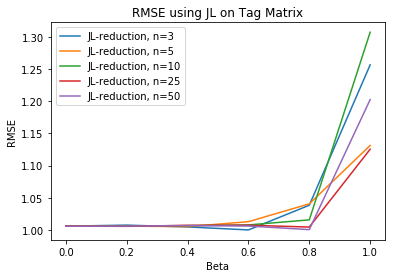

In [153]:
betas = [1 - alpha for alpha in alphas]
#plt.plot(betas, RMSE_baseline)
for i in range(len(num_component_hyperparams)):
    plt.plot(betas, RMSE_hyperparam_vals[i])
plt.legend(['JL-reduction, n=%d' %(n) for i, n in enumerate(num_component_hyperparams)])
plt.xlabel('Beta')
plt.ylabel('RMSE')
plt.title('RMSE using JL on Tag Matrix')

In [154]:
import random

def construct_missing_mat(Rmt, rate):
    partialMatrix = np.zeros(np.shape(Rmt))
    filled_positions = []
    for i in range(np.shape(Rmt)[0]):
        for j in range(np.shape(Rmt)[1]):
            if Rmt[i,j] != 0:
                filled_positions.append((i,j))
    numToKeep = int(rate*len(filled_positions))
    keptElems = random.sample(population=filled_positions, k=numToKeep)
    for (i,j) in keptElems:
        partialMatrix[i,j] = Rmt[i,j]
    return keptElems, partialMatrix


In [155]:
train_set, train_Rmt = construct_missing_mat(Rmt, rate=0.9)

m_1 = 0.01
m_2 = 0.01
factors = 25
lambda_1 = 0.1
lambda_2 = 0.1
learned_p = dict()
learned_q = dict()

for k in range(20):
    for (i,j) in train_set:
        r = train_Rmt[i,j]
        if i not in learned_q:
            learned_q[i] = np.array([np.random.random() - 0.5 for l in range(factors)])
        if j not in learned_p:
            learned_p[j] = np.array([np.random.random() - 0.5 for l in range(factors)])
        epsilon = 2*(r - np.dot(learned_q[i], learned_p[j]))
        learned_q[i] = learned_q[i] + m_1*(epsilon*learned_p[j] - 2*lambda_2*learned_q[i])
        learned_p[j] = learned_p[j] + m_2*(epsilon*learned_q[i] - 2*lambda_2*learned_p[j])
        
predicted_Rmt = np.zeros(np.shape(Rmt))

for i in learned_q:
    for j in learned_p:
        predicted_Rmt[i,j] = np.dot(learned_q[i], learned_p[j])

In [160]:
alphas = [a / 5.0 for a in range(0, 6)]
RMSE_baseline = []
RMSE_facs = []

for a in range(0, 6):
    alpha = a / 5.0
    beta = 1.0 - alpha
    print ('alpha: %.1f, beta: %.1f' %(alpha, beta))
    
    rmse_baseline = collaborative_filtering(Rmu, Rmu, Rmt, alpha = alpha, beta = beta)
    print ('Baseline Performance: ', rmse_baseline)
    RMSE_baseline.append(rmse_baseline)
    
    rmse_fac = collaborative_filtering(Rmu, Rmu, predicted_Rmt, alpha = alpha, beta = beta)
    print ('Latent Factor Analysis Performance: ', rmse_fac)
    RMSE_facs.append(rmse_fac)
    
    

alpha: 0.0, beta: 1.0
Baseline Performance:  1.0175792025175758
Latent Factor Analysis Performance:  1.0457322443388841
alpha: 0.2, beta: 0.8
Baseline Performance:  1.0049549541586613
Latent Factor Analysis Performance:  1.020405692349136
alpha: 0.4, beta: 0.6
Baseline Performance:  1.0055048698753635
Latent Factor Analysis Performance:  0.9953120945178665
alpha: 0.6, beta: 0.4
Baseline Performance:  1.0057635570294519
Latent Factor Analysis Performance:  0.9948458580938814
alpha: 0.8, beta: 0.2
Baseline Performance:  1.0059122003137193
Latent Factor Analysis Performance:  1.017619949775365
alpha: 1.0, beta: 0.0
Baseline Performance:  1.0060084808076784
Latent Factor Analysis Performance:  1.0060084808076784


Text(0.5, 1.0, 'Tag Matrix RMSE Latent Factor Analysis Comparison using 50 factors')

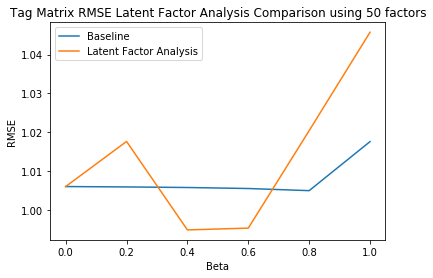

In [161]:
plt.plot(betas, RMSE_baseline)
plt.plot(betas, RMSE_facs)
plt.xlabel('Beta')
plt.ylabel('RMSE')
plt.legend(['Baseline', 'Latent Factor Analysis'])

plt.title('Tag Matrix RMSE Latent Factor Analysis Comparison using 50 factors')